In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, plot_confusion_matrix, confusion_matrix, mean_squared_error
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [2]:
df2 = pd.read_csv('diabetes_data_upload.csv')

In [3]:
df2.shape

(520, 17)

In [4]:
pd.set_option('display.max_columns', 17)

In [5]:
df = df2.copy()

# 1 - Limpeza e Transformações

Primeiro, vamos ver se há algum valor nulo:

In [6]:
df.isnull().sum().sum()

0

Não há. Vejamos o que cada coluna do *dataframe* é:

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 520 entries, 0 to 519
Data columns (total 17 columns):
Age                   520 non-null int64
Gender                520 non-null object
Polyuria              520 non-null object
Polydipsia            520 non-null object
sudden weight loss    520 non-null object
weakness              520 non-null object
Polyphagia            520 non-null object
Genital thrush        520 non-null object
visual blurring       520 non-null object
Itching               520 non-null object
Irritability          520 non-null object
delayed healing       520 non-null object
partial paresis       520 non-null object
muscle stiffness      520 non-null object
Alopecia              520 non-null object
Obesity               520 non-null object
class                 520 non-null object
dtypes: int64(1), object(16)
memory usage: 69.2+ KB


A maioria é do tipo objeto. Vamos exibir uma descrição dessas colunas e fazer um histograma da única coluna numérica:

In [8]:
df.select_dtypes(exclude='number').describe()

,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
count,520,520,520,520,520,520,520,520,520,520,520,520,520,520,520,520
unique,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
top,Male,No,No,No,Yes,No,No,No,No,No,No,No,No,No,No,Positive
freq,328,262,287,303,305,283,404,287,267,394,281,296,325,341,432,320


0.3293593578272701


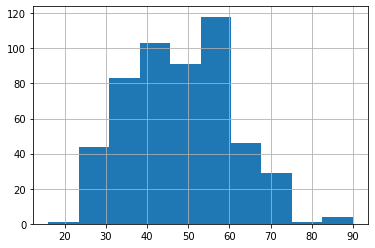

In [9]:
df['Age'].hist()
print(df['Age'].skew())

Não há muito o que fazer, apenas transformar `Yes`, `No`; `Male`, `Female`; e `Positive`,`Negative` em números, para o nosso modelo entender:

In [10]:
df.columns

Index(['Age', 'Gender', 'Polyuria', 'Polydipsia', 'sudden weight loss',
       'weakness', 'Polyphagia', 'Genital thrush', 'visual blurring',
       'Itching', 'Irritability', 'delayed healing', 'partial paresis',
       'muscle stiffness', 'Alopecia', 'Obesity', 'class'],
      dtype='object')

In [11]:
yesno = ['Polyuria', 'Polydipsia', 'sudden weight loss',
       'weakness', 'Polyphagia', 'Genital thrush', 'visual blurring',
       'Itching', 'Irritability', 'delayed healing', 'partial paresis',
       'muscle stiffness', 'Alopecia', 'Obesity']

for col in yesno:
    df[col] = df[col].replace({'Yes': 1, 'No': 0})

In [12]:
print(df['Gender'].unique())
print('-'*100)
print(df['class'].unique())

['Male' 'Female']
----------------------------------------------------------------------------------------------------
['Positive' 'Negative']


In [13]:
df['Gender'] = df['Gender'].replace({'Male': 1, 'Female': 0})
df['class'] = df['class'].replace({'Positive': 1, 'Negative': 0})

# 2 Análise

## 2.1 Idade e Sexo

Primeiro, vamos ver a relação da idade e do sexo com a incidencia de diabetes. Para idade vamos fazer um gráfico KDE e para o sexo um gráfico de barras.

Primeiro, criamos dois dataframes: um apenas com resultados positivos de diabetes, outro com resultado negativo:

In [14]:
positive = df[df['class'] == 1]
negative = df[df['class'] == 0]

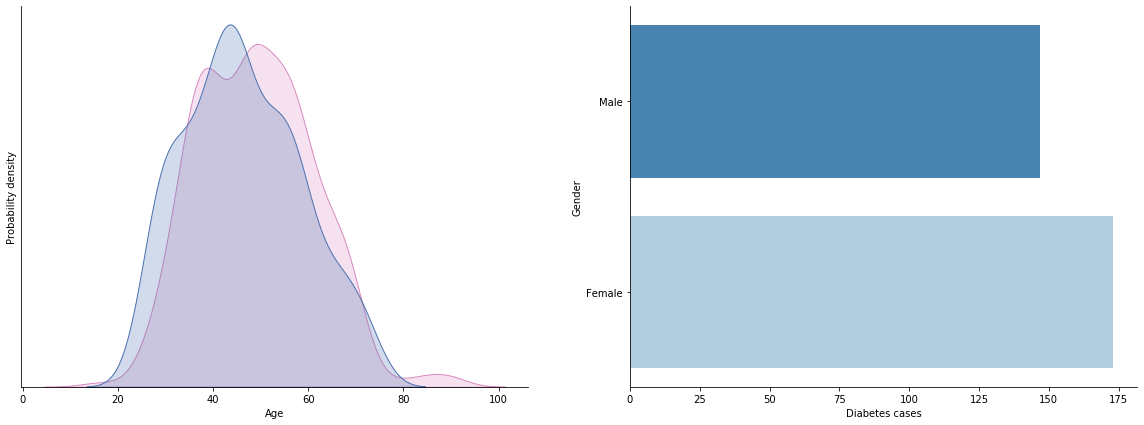

In [15]:
fig = plt.figure(figsize=(20,7))

ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

# aqui usamos o df2 em y pra mostrar `Male` e `Female` ao invés de 1 e 0.
sns.barplot(x=df['class'], y=df2['Gender'], estimator=sum, palette="Blues_r", ci=None, ax=ax2)
ax2.set(xlabel='Diabetes cases')

sns.kdeplot(positive['Age'], color='#da8bc3', shade=True, Label='Positive', ax=ax1)
sns.kdeplot(negative['Age'], color='#4c72b0', shade=True, Label='Negative', ax=ax1)
ax1.set(yticks=[])
ax1.set(xlabel='Age', ylabel='Probability density')

sns.despine(right=True)
plt.show()


**Idade**: Vemos que no começo dos anos 20 há uma prevalência de resultados negativos e no fim dos 50 anos começa uma prevalência de resultados positivos -- mas há uma grande área de intersecção. Ou seja, a idade talvez só seja útil nas caldas. Apesar disso, o nosso modelo (abaixo) usa a idade como o principal fator de decisão.

**Sexo**: Há uma uma certa tendencia de resultados positivos em mulheres.


## 2.2 Sintomas

Agora vamos ver a incidencia dos sintomas em resultados positivos e resultados negativos.

In [16]:
count_positive = positive.drop(columns=['Age', 'class', 'Gender']).sum(axis=0).sort_values(ascending=False)
count_negative = negative.drop(columns=['Age', 'class', 'Gender']).sum(axis=0).sort_values(ascending=False)

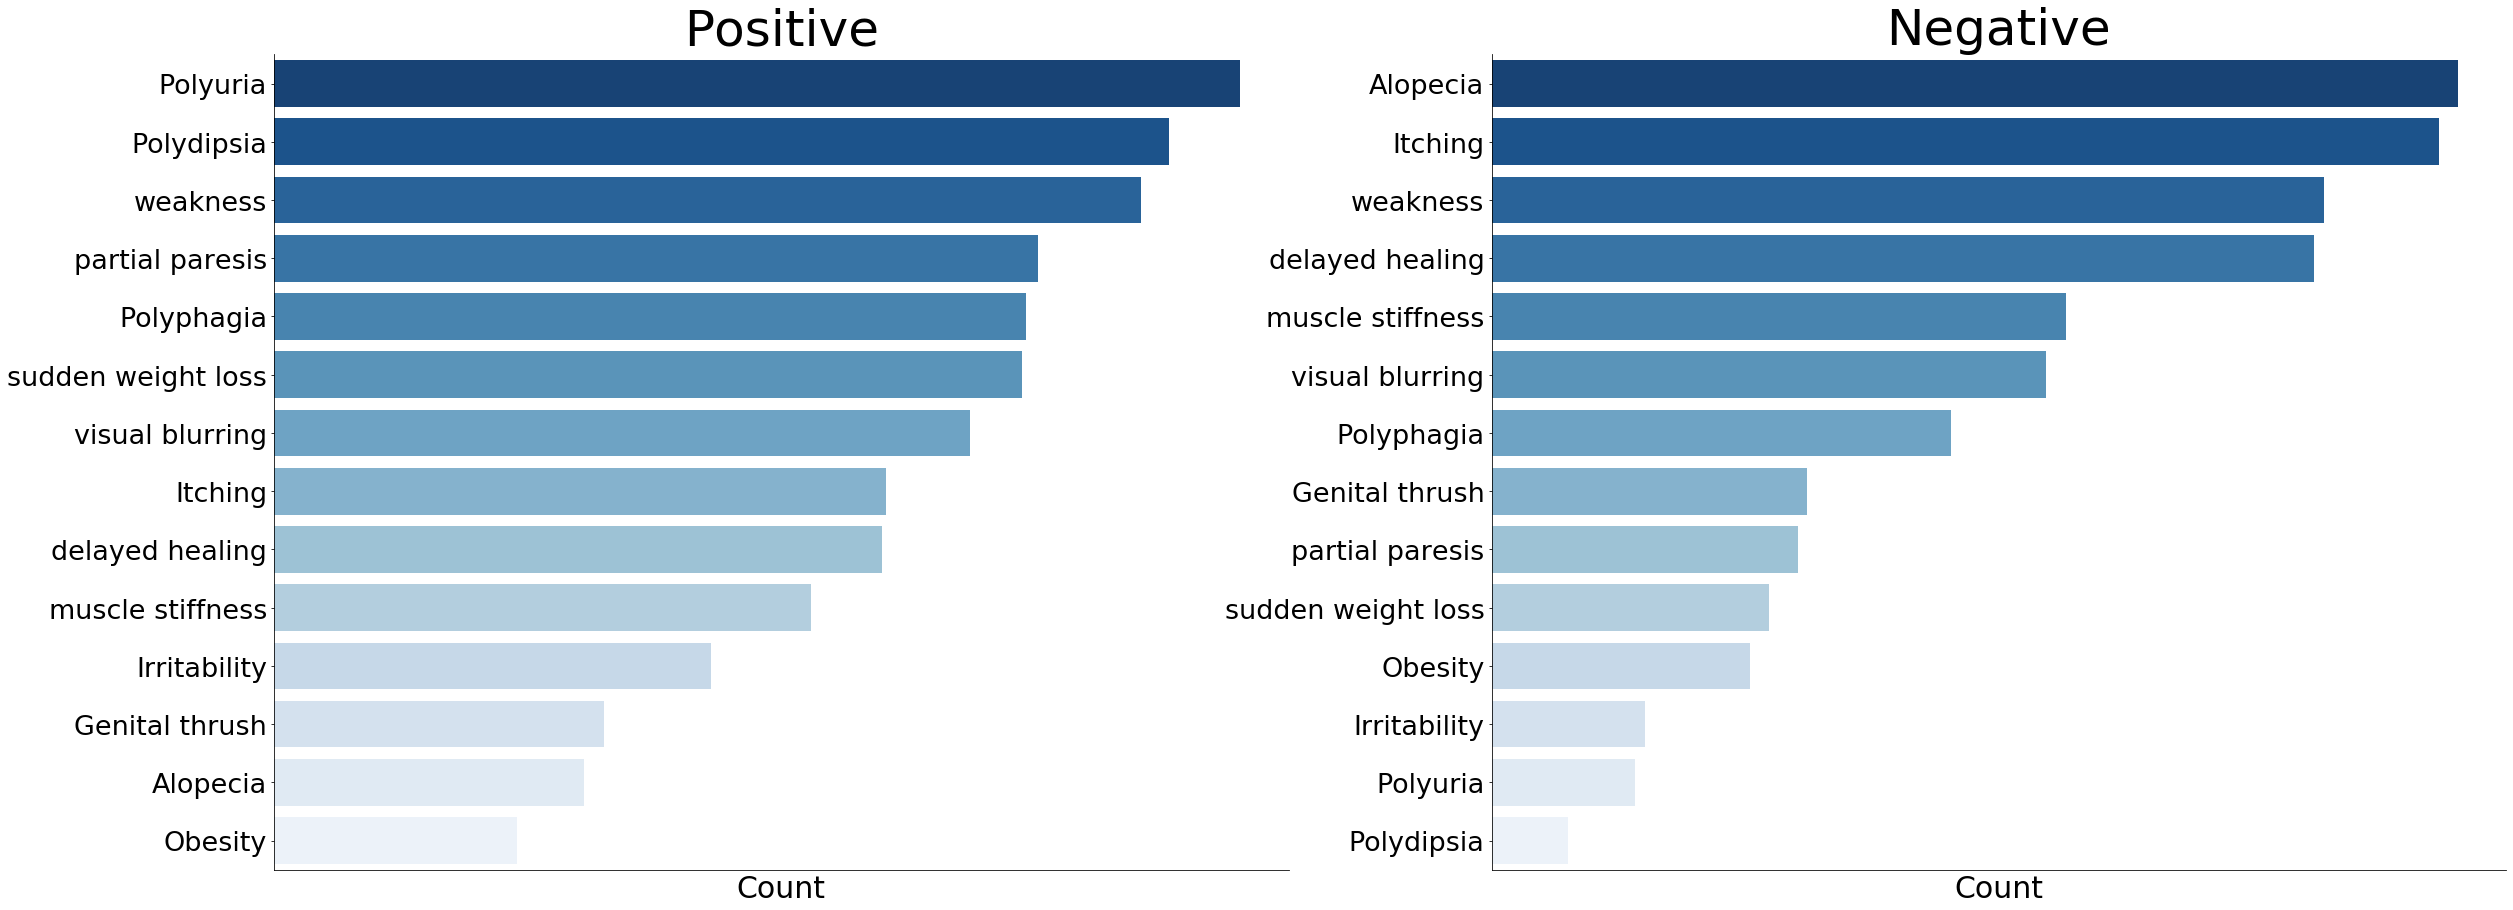

In [17]:
fig = plt.figure(figsize=(40,15))

ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

sns.barplot(x=count_positive, y=count_positive.index, palette="Blues_r", ax=ax1)
ax1.set_yticklabels(count_positive.index, size = 27)
ax1.set(xticks=[])
ax1.set_title('Positive', size=50)
ax1.set_xlabel("Count",fontsize=30)

sns.barplot(x=count_negative, y=count_negative.index, palette="Blues_r", ax=ax2)
ax2.set_yticklabels(count_negative.index, size = 27)
ax2.set(xticks=[])
ax2.set_title('Negative', size=50)
ax2.set_xlabel("Count",fontsize=30)

sns.despine(right=True)
plt.show()

Desses gráficos, os três sintomas mais relevantes para um resultado positivo são: *polyuria*, *polydipsia* e *partial paresis* -- *weakness*, apesar de maior incidencia em resultados positivos também aparece bastante em resultados negativos, ao passo que *partial paresis* aparece relativamente pouco em resultados negativos.

Fora isso, há uma combinação não elementar de como os outros sintomas contribuem para um resultado ou outro. Daqui não podemos escolher os atributos mais relevantes para nossos modelos: provavelmente eles são uma combinação não trivial dos sintomas (junto com idade e sexo, talvez) que o algoritimo usará para a classificação. Então aplicaremos métodos menos heurísticos para a escolha dos atributos.

## 2.3 Probabilidade de resultado positivo sendo homem com menos de 40 anos

Para saber qual as chances de um diagnostico positivo (dado os dados que temos) -- considerando apenas que o individuo é um homem com menos de 40 anos -- vamos aplicar o teorema de Bayes:
$$
P(A|B) = \frac{P(A)P(B|A)}{P(B)}.
$$

Em nosso caso: $A = \text{resultado positivo}$ e $B = \text{ser homem com menos de 40}$.

In [18]:
# probabilidade de ser homem < 40

P_H40 = df[df['Age'] < 40]['Gender'].value_counts(normalize=True)[1]

In [19]:
# probabilidade de ser homem < 40 dado que é positivo:

P_H40p = positive[positive['Age'] < 40]['Gender'].value_counts(normalize=True)[1]

In [20]:
# probabilidade de ser positivo:

P_p = df['class'].value_counts(normalize=True)[1]

In [21]:
# probabilidade de resultado positivo dado que é homem < 40:

P_pH40 = (P_p*P_H40p)/P_H40
print(P_pH40)

0.37325289089994973


Então, as chances são de pouco menos de `38%` -- houve uma queda nas chances de se diagnóstico positivo, de aproximadamente `61%` para esses quase `38%`.

## 2.4 Polyphagia

Para saber o papel da polyphagia no diagnóstico vamos novamente lançar mão do teorema de Bayes e calcular: a probabilidade do diagóstico positivo dado que há polyphagia e a probabilidade do diagnóstico dado que não há polyphagia.

Em suma:

$$
P(+ | p_{yes}) = \frac{P(+) P(p_{yes}| +)}{P(p_{yes})}, ~~~ P(- | p_{no}) = \frac{P(-) P(p_{no}| -)}{P(p_{no})},
$$

onde $+$/$-$ é o resultado positivo/negativo e $p_{yes}$/$p_{no}$ é a presença/ausência de polyphagia.

In [22]:
# probabilidade de ser positivo/negativo:

P_p = df['class'].value_counts(normalize=True)[1]
P_n = df['class'].value_counts(normalize=True)[0]

In [23]:
# probabilidade de polyphagia/sua ausência:

P_yes = df['Polyphagia'].value_counts(normalize=True)[1]
P_no = df['Polyphagia'].value_counts(normalize=True)[0]

In [24]:
# probabilidade de polyphagia dado positivo e ausência de polyphagia dado negativo:

P_yesp = positive['Polyphagia'].value_counts(normalize=True)[1]
P_non = negative['Polyphagia'].value_counts(normalize=True)[0]

In [25]:
P_pyes = (P_p*P_yesp)/P_yes
P_nno = (P_n*P_non)/P_no

print('Probabilidade de resultado positivo dado que há polyphagia: %.2f' % (P_pyes*100) + '%')
print('Probabilidade de resultado negativo dado que não há polyphagia: %.2f' % (P_nno*100) + '%')

Probabilidade de resultado positivo dado que há polyphagia: 79.75%
Probabilidade de resultado negativo dado que não há polyphagia: 53.71%


Ou seja, a presença da polyphagia aumenta a probabilidade de diagnóstico positivo: ela passa de ca. `61%` (i.e., o `P_p`) para quase `80%`.

A ausência de polyphagia também aumenta a probabilidade de resultado negativo: de aproximadamente `38%` para quase `54%` -- um resultado mais modesto, o que sugere que a presença de polyphagia é mais importante para o resultado positivo do que a ausência é para o resultado negativo.

# 3 - Modelos

## 3.1 Preparação

Antes de construir nossos modelos vamos ver se há alguma correlação entre as variáveis.

### 3.1.1 Correlação

Vamos ver alguma correlação entre as colunas: se houver uma correlação muito forte (vamos definir forte como >= 0.7) vamos eliminar uma das colunas, pois isso duplicaria uma mesma informação e poderia causar distorções em modelos de arvore, por exemplo.

In [26]:
corr = df.corr()

Abaixo, vemos se há uma correlação maior que `0.7` fora da diagonal da matriz de correlações. Não há.

In [27]:
corr[(corr.iloc[:,:] != 1.0) & (corr > 0.7)].notnull().sum()

Age                   0
Gender                0
Polyuria              0
Polydipsia            0
sudden weight loss    0
weakness              0
Polyphagia            0
Genital thrush        0
visual blurring       0
Itching               0
Irritability          0
delayed healing       0
partial paresis       0
muscle stiffness      0
Alopecia              0
Obesity               0
class                 0
dtype: int64

### 3.1.2 Critério e exibição dos resultados

Abaixo uma função para exibir os resultados dos modelos. Vamos usar duas métricas: Accuracy e ROC AUC.

Escolhemos incluir o Accuracy score para incluir a apresentação menos técnica, já que é uma métrica mais intuitiva: o quanto acertamos na classificação comparado com o total.

Mas para problemas com dados desequilibrados (como é este caso: os dados são levemente desequilibrados: as classificações positivas são 1.6 vezes as classificações negativas (vide infra). Apesar disso, *a priori* não faremos nenhuma modificação nos dados: vamos ver como o modelo se comporta e, além disso, o modelo que usaremos tende a ser robusto com dados desequilibrados) o accuracy score não é bom: ele não captura os erros de classificar algo como falso. A AUC leva em conta as classificações erradas.

Vamos demonstrar isso abaixo: um modelo ingênuo é simplesmente chutar que o diagnóstico é positivo sempre. Isso nos dá um accuracy score de ca. `61%`, mas um roc auc score de `.5`: ou seja, o mesmo que um chute aleatório.

In [28]:
# leve desequilibrio

len(positive)/len(negative)

1.6

In [29]:
def print_results(y_train, y_test, y_pred_train, y_pred_test):
    roc_auc_train = roc_auc_score(y_train, y_pred_train)
    roc_auc_test = roc_auc_score(y_test, y_pred_test)
    acc_train = accuracy_score(y_train, y_pred_train)
    acc_test = accuracy_score(y_test, y_pred_test)

    print('Accuracy train:', acc_train)
    print('ROC AUC train: ', roc_auc_train)
    print('-'*100)
    print('Accuracy test:', acc_test)
    print('ROC AUC test: ', roc_auc_test)

### 3.1.3 Divisão entre `train` e `test`:

In [30]:
x = df.drop(columns=['class'])
y = df['class']

X_train, X_test, y_train, y_test = train_test_split(x, y, stratify=y, random_state = 1)

Passamos o argumento `stratify` para preservar a proporção de positivos e negativos no *train set* e no *test set*.

### 3.1.4 Modelo ingênuo:

E se classificarmos tudo como positivo?

In [31]:
y_pred_test = np.ones(len(y_test))
y_pred_train = np.ones(len(y_train))

In [32]:
print_results(y_train, y_test, y_pred_train, y_pred_test)

Accuracy train: 0.6153846153846154
ROC AUC train:  0.5
----------------------------------------------------------------------------------------------------
Accuracy test: 0.6153846153846154
ROC AUC test:  0.5


Ou seja, ocorre exatamente o que dissemos: o accuracy score é razoável/bom (ainda mais se comparado com o que esperamos de um chute: `50%`), enquanto o roc auc score é ruim.

## 3.2 XGBoost

Agora vamos treinar o xgboost nos nossos dados, e fazer as estimativas para o *train* e *test sets*

In [33]:
xgb_cl = xgb.XGBClassifier(eval_metric='auc', use_label_encoder=False, seed=1)

xgb_cl.fit(X_train, y_train, verbose=0, early_stopping_rounds=50, eval_set=[(X_test, y_test)])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, random_state=1, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, seed=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

In [34]:
y_pred_train = xgb_cl.predict(X_train)
y_pred_test = xgb_cl.predict(X_test)

Accuracy train: 0.9897435897435898
ROC AUC train:  0.9904166666666667
----------------------------------------------------------------------------------------------------
Accuracy test: 0.9538461538461539
ROC AUC test:  0.9625


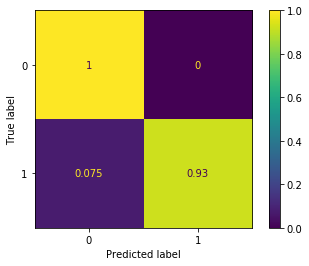

In [35]:
print_results(y_train, y_test, y_pred_train, y_pred_test)
plot_confusion_matrix(xgb_cl, X_test, y_test, normalize='true')

Vamos visualizar uma árvore, apenas por costume:

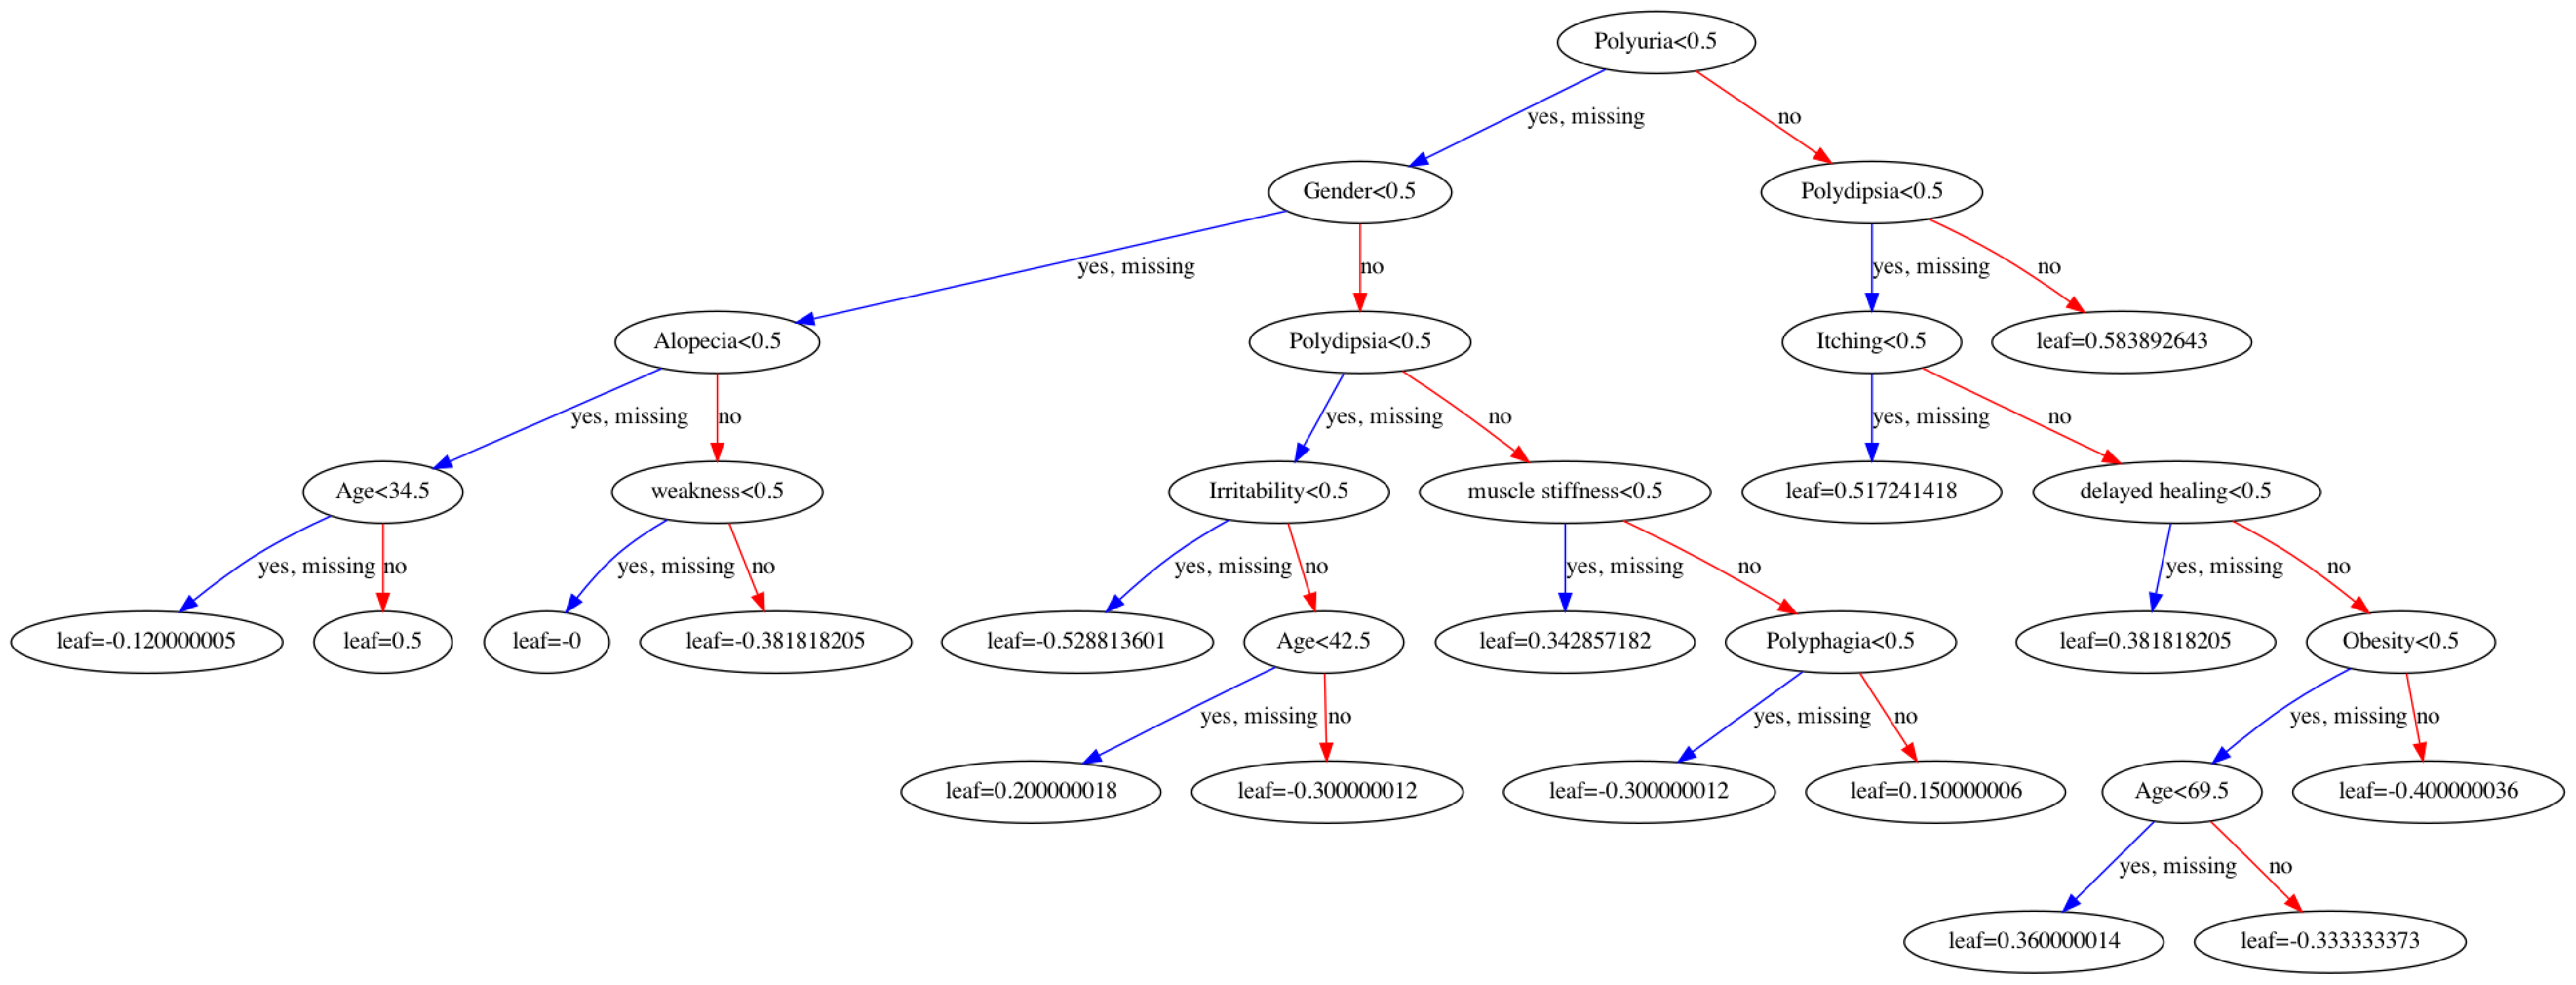

In [36]:
fig, ax = plt.subplots(figsize=(70, 70))
xgb.plot_tree(xgb_cl, ax=ax)
plt.show()

### 3.2.1 Feature importance e retreinamento

Há várias formas de calcular a importância das propriedades. Aqui vamos optar por usar o método `get_score` do xgboost, com o parâmetro `weight`, que seleciona as propriedades de acordo com o número de vezes que elas são usadas para dividir as árvores, com vista a maximizar a métrica de avaliação. Com essa escolha esperamos fazer uma otimização melhor do que outros métodos (como, por exemplo, o [shap](https://shap.readthedocs.io/en/latest/)).

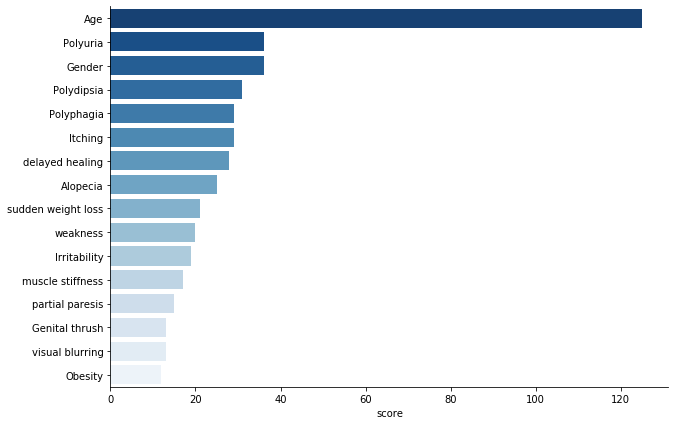

In [37]:
features_score = xgb_cl.get_booster().get_score(importance_type='weight')
keys = list(features_score.keys())
values = list(features_score.values())

feature_importance = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)

fig = plt.figure(figsize=(10,7))

sns.barplot(x=feature_importance['score'], y=feature_importance.index, palette="Blues_r")
sns.despine(right=True)

In [38]:
least_five = list(feature_importance.tail().index)

In [39]:
X_train = X_train.drop(columns=least_five)

X_test = X_test.drop(columns=least_five)

In [40]:
xgb_cl = xgb.XGBClassifier(eval_metric='auc', use_label_encoder=False, seed=1)
xgb_cl.fit(X_train, y_train, verbose=0, early_stopping_rounds=50, eval_set=[(X_test, y_test)])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, random_state=1, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, seed=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

Accuracy train: 0.9897435897435898
ROC AUC train:  0.9904166666666667
----------------------------------------------------------------------------------------------------
Accuracy test: 0.9384615384615385
ROC AUC test:  0.95


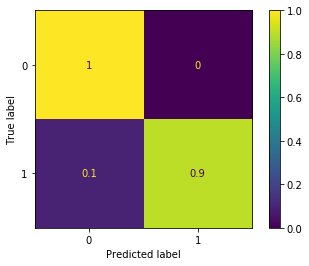

In [41]:
y_pred_train = xgb_cl.predict(X_train)
y_pred_test = xgb_cl.predict(X_test)

print_results(y_train, y_test, y_pred_train, y_pred_test)
plot_confusion_matrix(xgb_cl, X_test, y_test, normalize='true')

### 3.2.2 Otimização

O modelo assim já está bom, mas podemos pensar em melhorá-lo. 

O xgboost é um algorítimo bom por -- além de ser um algorítimo do tipo gradient boosting, que é uma melhora sobre random forests (que, por sua vez, é ótimo para classificações e regressões) -- ser altamente personalizável: podemos controlar vários parâmetros e fazer um *fine tuning* do modelo. Esse processo de escolha dos parâmetros -- *hyperparameter tuning* -- demanda muito tempo (computacional).

No nosso caso não parece ser tão necessário empregar um método tão pesado. Vamos, ao invés disso fazer um ajuste no *cut off* do nosso modelo: quando aplicamos algum algorítimo de classificação o que temos, na verdade, são probabilidades: para cala linha das features `X` temos a probabilidade de (neste caso) o resultado ser `0` ou `1`: por exemplo, para dada linha de `X`, `X[0]`, temos `y_pred[0] = [0.3, 0.7]`. 

*Cut off* é o ponto que escolhemos para decidir se, por exemplo, `0.7` é suficientemente alto para rejeitar que `y_pred[0] = 0` (e, portanto, igual a `1`).

Quando usamos o método `predict` estamos concordando implicitamente em usar *cut off* igual a `0.5`. Isso, na verdade, não é algo que sempre queremos. Temos que fazer uma escolha: qual tipo de erro queremos minimizar (e, consequentemente, qual irá aumentar): erro do tipo I ou do tipo II -- respectivamente, erro classificar falsos positivos e falsos negativos.

Vamos aqui tentar aumentar o ROC AUC score sem nos preocuparmos que tipo de erro estamos minimizando. Para isso vamos ver o `roc_auc_score` como uma função do *cut off* e achar qual valor maximiza esse score.

Para acessar as probabilidades das classificações usamos o método `predict_proba`:

In [42]:
y_prob_train = xgb_cl.predict_proba(X_train)
y_prob_test = xgb_cl.predict_proba(X_test)

A distribuição das probabilidades é a seguinte:

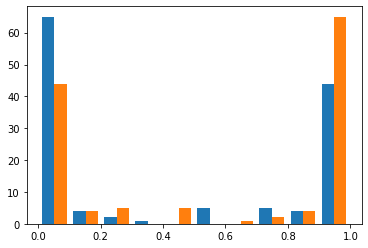

In [43]:
plt.hist(y_prob_test[:,:])
plt.show()

Abaixo fazemos um gráfico do roc auc score pomo função do *cut off*.

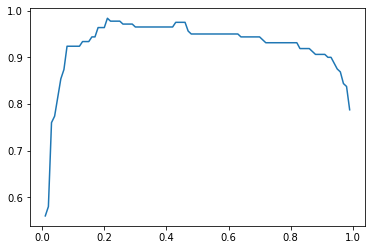

In [44]:
cutoffs = np.arange(0.01, 1, 0.01)
aucscore = {}
for c in cutoffs:
    aucscore[c] = roc_auc_score(y_test, np.where(y_prob_test[:,1] > c, 1, 0))

plt.plot(cutoffs, list(aucscore.values()))
plt.show()

Para saber o melhor *cut off* invocamos a função `max` aplicada ao dicionário `aucscore` com as possíveis chaves, para retornar qual chave com o maior valor.

In [45]:
best_cutoff = max(aucscore, key = aucscore.get)
print(best_cutoff)

0.21000000000000002


Por fim, definimos nossas previsões com esse *cut off*:

In [46]:
y_pred_train = np.where(y_prob_train[:,1] > best_cutoff, 1, 0)
y_pred_test = np.where(y_prob_test[:,1] > best_cutoff, 1, 0)

In [47]:
print_results(y_train, y_test, y_pred_train, y_pred_test)

Accuracy train: 0.982051282051282
ROC AUC train:  0.9766666666666667
----------------------------------------------------------------------------------------------------
Accuracy test: 0.9846153846153847
ROC AUC test:  0.98375


In [48]:
confusion_matrix(y_test, y_pred_test, normalize='true')

array([[0.98  , 0.02  ],
       [0.0125, 0.9875]])

Conseguimos aumentar a classificação de tp (true positive) diminuindo somente um pouco a classificação dos tn (diminuimos o erro II por um fator de `87.5%`, ao passo que só diminuimos a classificação dos tn por um fator de `2%`). No final, temos um resultado mais equilibrado.

Também conseguimos reduzir a diferença entre roc auc do *train set* e do *test set*. Essa diferença é um indicador de *overfitting* e, principalmente em modelos do tipo arvore é importante acompanhar isso, pois eles tendem a "*overfittar*". Neste caso, a diferença já era pequena mas agora é menor -- inclusive, houve uma inversão: roc auc do *test set* é maior que a do *train*. (isso é normal, pois a otimização do *cut off* foi feita no *test set*).

# 4 - Possíveis dificuldades

Nesta seção consideraremos possíveis dificuldades que o modelo pode encontrar em algum outro *dataset*. Vamos apenas falar das dificuldades, exemplificar e esboçar uma solução. Não teremos como objetivo otimizar os modelos abaixo, mas apenas mostrar um caminho inicial.

Considerando este modelo, mas treinado em um outro dataset: essa pergunta pode ser entendida de modo geral ou de modo particular.

**De modo geral**, se pensarmos em outros problemas que o modelo pode atacar mas que ele teria dificuldade: neste caso posso citar, por exemplo, o caso de regressões com *targets* cuja distribuição tem uma calda longa. Neste caso, modelos do tipo *gradient boosting* são sensíveis a *outliers*, (em alguns casos, mesmo mudando a *loss function*) e uma transformação ingênua das variáveis pode não dar conta (por causa da desigualdade de Jensen). Uma análise mais sútil é necessária. De modo geral, neste caso, é bom também definir bem o que é o sucesso: usar desvios absolutos da média, ao invés do desvio padrão, por exemplo.

Outro fator que dificulta esse modelo é a presença de *noise*: informações que não são relevantes, mas que fazem parte do dataset -- esse é um problema de modelos árvore em geral. Isso é resolvido mais fácilmente que o problema anterior, via um ajuste fino dos vários parâmetros do xgboost. Controlando a complexidade do modelo com `max_depth`, `min_child_weight` e o `gamma`; e adicionando aleatoriedade ao modelo com `subsample` e `colsample_bytree`.

**De modo particular**, i.e., se a pergunta se refere a este problema em particular, se o dataset fosse diferente, poderíamos ter, ao menos, dois problemas:

## 4.1 Desequilibrio para casos negativos

de cara há algo de estranho nesses dados, a saber, há um desequilibrio nos alvos. Há mais casos positivos do que negativos. Mas o modelo detecta os casos negativos mais fácilmente -- talvez indícios de ausência são mais forte do que de presença, neste caso. Então, se os dados fossem mais equilibrados haveria um problema no modelo.

Vamos ver um exemplo disso ocorrendo: vamos fazer um *under sampling* dos resultados positivos, para que ele se iguale aos resultados negativos, e um *over sampling* (gerando dados sintéticos usando SMOTE) dos dados negativos. Vejamos o que isso nos dará:

In [49]:
df['class'].value_counts()

1    320
0    200
Name: class, dtype: int64

In [50]:
x = df.drop(columns=['class'])
y = df['class']

In [51]:
un = RandomUnderSampler(random_state=1, sampling_strategy={1:200}, replacement=False)
sm = SMOTE(random_state=1, sampling_strategy={0:250})
x, y = sm.fit_resample(x, y)
x, y = un.fit_resample(x, y)
y.value_counts()

0    250
1    200
Name: class, dtype: int64

In [52]:
X_train, X_test, y_train, y_test = train_test_split(x, y, stratify=y, random_state = 1)

In [53]:
xgb_cl = xgb.XGBClassifier(eval_metric='auc', use_label_encoder=False, seed=1)
xgb_cl.fit(X_train, y_train, verbose=0, early_stopping_rounds=50, eval_set=[(X_test, y_test)])

features_score = xgb_cl.get_booster().get_score(importance_type='weight')
keys = list(features_score.keys())
values = list(features_score.values())

feature_importance = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)

least_five = list(feature_importance.tail().index)
print(least_five)

['visual blurring', 'Genital thrush', 'Obesity', 'weakness', 'partial paresis']


In [54]:
X_train = X_train.drop(columns=least_five)
X_test = X_test.drop(columns=least_five)

Accuracy train: 0.9940652818991098
ROC AUC train:  0.9939928698752227
----------------------------------------------------------------------------------------------------
Accuracy test: 0.9469026548672567
ROC AUC test:  0.94


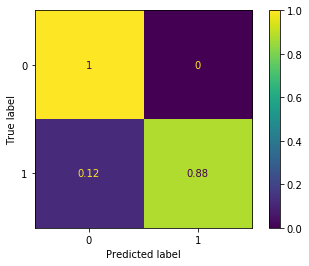

In [55]:
xgb_cl = xgb.XGBClassifier(eval_metric='auc', use_label_encoder=False, seed=1)
xgb_cl.fit(X_train, y_train, verbose=0, early_stopping_rounds=50, eval_set=[(X_test, y_test)])

y_pred_train = xgb_cl.predict(X_train)
y_pred_test = xgb_cl.predict(X_test)

print_results(y_train, y_test, y_pred_train, y_pred_test)
plot_confusion_matrix(xgb_cl, X_test, y_test, normalize='true')

Um começo de solução para essa dificuldade é rebalancear os dados novamente: retirar um pouco dos excedentes e gerar um pouco mais dos deficitários:

In [56]:
y.value_counts()

0    250
1    200
Name: class, dtype: int64

In [57]:
un = RandomUnderSampler(random_state=1, sampling_strategy={0:200}, replacement=False)
sm = SMOTE(random_state=1, sampling_strategy={1:250})
x, y = sm.fit_resample(x, y)
x, y = un.fit_resample(x, y)
y.value_counts()

1    250
0    200
Name: class, dtype: int64

In [58]:
X_train, X_test, y_train, y_test = train_test_split(x, y, stratify=y, random_state = 1)

Accuracy train: 0.9940652818991098
ROC AUC train:  0.9939928698752227
----------------------------------------------------------------------------------------------------
Accuracy test: 0.9646017699115044
ROC AUC test:  0.9620634920634921


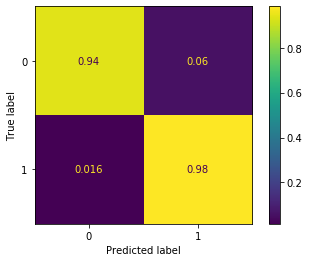

In [59]:
xgb_cl = xgb.XGBClassifier(eval_metric='auc', use_label_encoder=False, seed=1)
xgb_cl.fit(X_train, y_train, verbose=0, early_stopping_rounds=50, eval_set=[(X_test, y_test)])

y_pred_train = xgb_cl.predict(X_train)
y_pred_test = xgb_cl.predict(X_test)

print_results(y_train, y_test, y_pred_train, y_pred_test)
plot_confusion_matrix(xgb_cl, X_test, y_test, normalize='true')

Já conseguimos elevar o roc auc score de `.94` para `.96`, o que é um bom começo; e poderíamos continuar trabalhando neste problema, mas vamos parar aqui.

## 4.2 A presença de `NaN`s

Um problema que o modelo pode encontrar é a falta de informação. Para simular este problema vamos distribuir `NaN`s pela coluna que tem maior correlação com o *target* `class` (isso é apenas um exemplo de um caso, mas quando há valores nulos em um dataframe, cada caso é um caso).

In [60]:
df.corr()['class'].sort_values(ascending=False)

class                 1.000000
Polyuria              0.665922
Polydipsia            0.648734
sudden weight loss    0.436568
partial paresis       0.432288
Polyphagia            0.342504
Irritability          0.299467
visual blurring       0.251300
weakness              0.243275
muscle stiffness      0.122474
Genital thrush        0.110288
Age                   0.108679
Obesity               0.072173
delayed healing       0.046980
Itching              -0.013384
Alopecia             -0.267512
Gender               -0.449233
Name: class, dtype: float64

Vamos, então, distribuir valores nulos na coluna `Polyuria`, de modo que os valores nulos não ultrapasse `7%` dos valores totais:

In [61]:
np.random.seed(3)
uria_nan = df['Polyuria'].mask(np.random.random(df['Polyuria'].shape)<0.07)

In [62]:
df3 = df.copy()

In [63]:
df3['Polyuria'] = uria_nan

In [64]:
df3.isnull().sum()

Age                    0
Gender                 0
Polyuria              35
Polydipsia             0
sudden weight loss     0
weakness               0
Polyphagia             0
Genital thrush         0
visual blurring        0
Itching                0
Irritability           0
delayed healing        0
partial paresis        0
muscle stiffness       0
Alopecia               0
Obesity                0
class                  0
dtype: int64

Vejamos o que o modelo nos dirá se simplesmente descartarmos as linhas com valores nulos:

In [65]:
df_drop = df3.dropna()

In [66]:
x = df_drop.drop(columns=['class'])
y = df_drop['class']

In [67]:
X_train, X_test, y_train, y_test = train_test_split(x, y, stratify=y, random_state = 1)

Accuracy train: 0.9972451790633609
ROC AUC train:  0.9977973568281938
----------------------------------------------------------------------------------------------------
Accuracy test: 0.9508196721311475
ROC AUC test:  0.9562356979405033


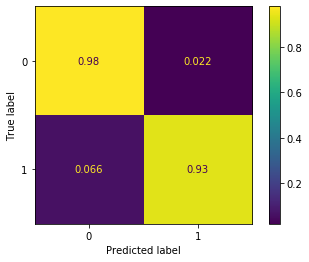

In [68]:
xgb_cl = xgb.XGBClassifier(eval_metric='auc', use_label_encoder=False, seed=1)
xgb_cl.fit(X_train, y_train, verbose=0, early_stopping_rounds=50, eval_set=[(X_test, y_test)])

y_pred_train = xgb_cl.predict(X_train)
y_pred_test = xgb_cl.predict(X_test)

print_results(y_train, y_test, y_pred_train, y_pred_test)
plot_confusion_matrix(xgb_cl, X_test, y_test, normalize='true')

Agora, se ao invés, substituirmos os valores nulos por estimativas baseadas no que são os valores de `Polyuria` quando alguma variável correlacionada com ela é um outro valor -- i.e., usaremos *K-Nearest Neighbors* para estimar os valores nulos de `Polyuria`.

In [69]:
df3.corr()['Polyuria'].sort_values(ascending=False)

Polyuria              1.000000
class                 0.648871
Polydipsia            0.598896
sudden weight loss    0.457065
partial paresis       0.438333
Polyphagia            0.374093
weakness              0.274181
visual blurring       0.258736
Irritability          0.219878
Age                   0.202436
muscle stiffness      0.155784
delayed healing       0.155249
Obesity               0.117808
Itching               0.101104
Genital thrush        0.078190
Alopecia             -0.149659
Gender               -0.271562
Name: Polyuria, dtype: float64

In [70]:
X_train, X_test, y_train, y_test = train_test_split(df_drop[['Polydipsia']] , df_drop['Polyuria'], random_state = 0)

In [71]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor(n_neighbors=10)
knn.fit(X_train, y_train)
predictions_test = knn.predict(X_test)
predictions_train = knn.predict(X_train)

In [72]:
print('RMSE test:', np.sqrt(mean_squared_error(y_test, predictions_test)))
print('RMSE train:', np.sqrt(mean_squared_error(y_train, predictions_train)))
print('-'*100)
print('Standard Deviation para o y_test:', np.std(y_test))

RMSE test: 0.3849632726786745
RMSE train: 0.4069641688290799
----------------------------------------------------------------------------------------------------
Standard Deviation para o y_test: 0.49892386208305584


In [73]:
X_nan = np.array(df3[df3['Polyuria'].isnull()]['Polydipsia']).reshape(-1, 1)
predictions_nan = knn.predict(X_nan)
predictions_nan

array([0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.2, 0.8, 0.2, 0.2, 0.8, 0.2,
       0.2, 0.2, 0.2, 0.2, 0.2, 0.8, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
       0.2, 0.8, 0.8, 0.8, 0.8, 0.2, 0.2, 0.2, 0.2])

In [74]:
predictions_nan = np.where(predictions_nan > 0.5, 1, 0)
predictions_nan

array([1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0])

In [75]:
values_nan = pd.Series(predictions_nan, index=df3[df3['Polyuria'].isnull()].index)
df3['Polyuria'].fillna(values_nan, inplace=True)

In [76]:
x = df3.drop(columns=['class'])
y = df3['class']
X_train, X_test, y_train, y_test = train_test_split(x, y, stratify=y, random_state = 1)

Accuracy train: 1.0
ROC AUC train:  1.0
----------------------------------------------------------------------------------------------------
Accuracy test: 0.9692307692307692
ROC AUC test:  0.975


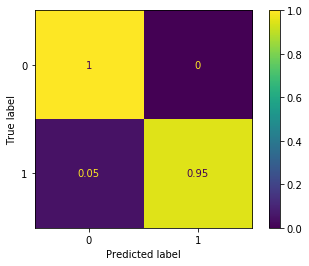

In [77]:
xgb_cl = xgb.XGBClassifier(eval_metric='auc', use_label_encoder=False, seed=1)
xgb_cl.fit(X_train, y_train, verbose=0, early_stopping_rounds=50, eval_set=[(X_test, y_test)])

y_pred_train = xgb_cl.predict(X_train)
y_pred_test = xgb_cl.predict(X_test)

print_results(y_train, y_test, y_pred_train, y_pred_test)
plot_confusion_matrix(xgb_cl, X_test, y_test, normalize='true')

# 5 - Conclusão


Nosso modelo principal (seção 3.2.2) conseguiu um roc auc score de c. `0.98`, e uma precisão também de c. `0.98`. Conseguimos este resultado sem nenhum *tuning* dos hyperparâmetros.